# Text-based Paper Clustering

Author: Rafael Ballestiero

In [301]:
import os, re
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress.fastprogress import master_bar, progress_bar

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [352]:
%matplotlib inline

plt.rcParams['figure.figsize']=[30,20]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

plt.style.use('seaborn-whitegrid')

## Corpus Vectorization

In order to vectorize any corpus, we must create a tokenizer to extract tokens from each document. Although we could simply use the preprocessed words as they are, it is also interesting to stem them to group together ideas with similar stems.

In [29]:
from nltk import word_tokenize, PorterStemmer

In [34]:
stemmer = PorterStemmer()

def build_tokenizer(exceptions):
    def _tokenizer(text):
        return [stemmer.stem(token) if token not in exceptions else token for token in word_tokenize(text)]
    
    return _tokenizer

In [87]:
def build_stem2token(iterator, abbreviations):
    frequency_map = {}
    
    def _do_stem2token(agg):
        try:
            _, text = next(iterator)
            
            for token in word_tokenize(text):
                frequency_map[token] = frequency_map.get(token, 0) + 1
                
                if token not in abbreviations:
                    stem = stemmer.stem(token)
                    
                    # only add token to aggregator if (i) not present or (ii) token is more popular than current one
                    if stem not in agg.keys() or frequency_map[token] > frequency_map[agg[stem]]:
                        agg[stem] = token

            return _do_stem2token(agg)
        except StopIteration:
            return agg
        
    result = {}
    return _do_stem2token(result)

## Clustering Methods

In [245]:
def nmf_decomp(X, n_clusters, frobenius=True, random_state=42, **kwargs):
    if frobenius:
        nmf = NMF(n_components=n_clusters, random_state=random_state, shuffle=True, alpha=.1, **kwargs)
    else:
        nmf = NMF(n_components=n_clusters, random_state=random_state, shuffle=True, 
                  beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, **kwargs)

    # since our samples are rows and not columns, H is the document cluster matrix and W is the topic keywords matrix.
    H = nmf.fit_transform(X)
    W = nmf.components_
    
    return H, W

def nmf_consensus_matrix(X, n_clusters, r, T, random_state=42):
    assert 0 < r and r <= 1
        
    n_documents = X.shape[0]

    C = np.zeros((T, n_documents, n_documents))
    S = np.zeros((T, n_documents, n_documents))

    for t in range(T):
        # sample random indices with sampling rate r
        doc_idx = np.random.choice(n_documents, size=int(n_documents * r), replace=False)
        subset_scores = X[doc_idx, :]

        # apply NMF decomposition and get cluster labels
        sH, _ = nmf_decomp(subset_scores, n_clusters, random_state=random_state)
        subset_labels = sH.argmax(axis=1)

        # idx map to get the subset index of the original document index
        doc_idx_map = {doc_i: sub_i for (sub_i, doc_i) in enumerate(doc_idx)}

        for doc_i in range(n_documents):
            for doc_j in range(doc_i, n_documents):
                if doc_i in doc_idx and doc_j in doc_idx:
                    S[t, doc_i, doc_j] = 1
                    # add mirror value
                    S[t, doc_j, doc_i] = 1

                    # get document's subset ids
                    sub_i, sub_j = doc_idx_map[doc_i], doc_idx_map[doc_j]

                    if subset_labels[sub_i] == subset_labels[sub_j]:
                        C[t, doc_i, doc_j] = 1
                        # add mirror value
                        C[t, doc_j, doc_i] = 1


    confusion_matrix = np.divide(np.sum(C, axis=0), np.sum(S, axis=0))

    # handle NaN values due to division by 0 (i.e., no co-occurence between documents in any sample)
    return np.nan_to_num(confusion_matrix, 0)

def nmf_dispersion(concensus_matrix):
    assert concensus_matrix.shape[0] == concensus_matrix.shape[1]
    n = concensus_matrix.shape[0]
    
    return (4 / n**2) * sum(sum((concensus_matrix[i, j] - 0.5)**2 for j in range(n)) for i in range(n))

In [249]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from PyPDF2 import PdfFileMerger

class CorpusModel:
    def __init__(self, corpus_clusterer, name, **parameters):
        self.corpus_clusterer = corpus_clusterer
        self.name = name
        
        self.random_state = 42
        
        self.model = TfidfVectorizer(
            tokenizer=corpus_clusterer.tokenizer,
            **parameters
        )
        
        self.scores = self.model.fit_transform(corpus_clusterer.corpus)
        
        self.nmf_decomps = {}
        self.dispersion_coefficients = {}
        
    def format_keyword(self, keyword):
        return " ".join([self.corpus_clusterer.stem2token.get(w, w) for w in keyword.split()])
    
    def get_nmf_decomp(self, n_clusters, **kwargs):
        if n_clusters not in self.nmf_decomps.keys():
            self.nmf_decomps[n_clusters] = nmf_decomp(self.scores, n_clusters, random_state=self.random_state, **kwargs)
            
        return self.nmf_decomps[n_clusters]

    def nmf_cluster_labels(self, n_clusters):
        H, _ = self.get_nmf_decomp(n_clusters)
        
        return H.argmax(axis=1)
    
    def nmf_topic_keywords(self, n_clusters, word_count=10):
        _, W = self.get_nmf_decomp(n_clusters)
        
        result = []
        
        feature_names = self.model.get_feature_names()

        for topic_id, topic in enumerate(W):
            top_words = topic.argsort()[::-1][:word_count]

            result.append([self.format_keyword(feature_names[i]) for i in top_words])

        return result
    
    def calculate_dispersion_coefficient(self, n_clusters, r=0.8, T=50):
        if n_clusters not in self.dispersion_coefficients:
            C = nmf_consensus_matrix(self.scores, n_clusters, r, T, random_state=self.random_state)
            self.dispersion_coefficients[n_clusters] = nmf_dispersion(C)
            
        return self.dispersion_coefficients[n_clusters]
        
class CorpusClusterer:
    def __init__(self, name, df, corpus):
        self.name = name
        self.df = df
        self.corpus = corpus
        
        self.models = {}
        
        self.maybe_load_abbreviations()
        
        self.stem2token = build_stem2token(self.corpus.iteritems(), self.abbreviations)
        self.tokenizer = build_tokenizer(self.abbreviations)
        
    def maybe_load_abbreviations(self):
        if "abbreviations.pkl" in os.listdir(f"./data/{self.name}"):
            with open(f"./data/{self.name}/abbreviations.pkl", "rb") as abbfile:
                self.abbreviations = pkl.load(abbfile)
        else:
            self.abbreviations = []
                
    def add_tfidf_model(self, model_name, **model_params):
        self.models[model_name] = CorpusModel(self, model_name, **model_params)
        

## Service Innovation

In [168]:
service_innovation_df = pd.read_csv("./data/service_innovation/clean.csv", index_col=0)
service_innovation_corpus = pd.read_csv("./data/service_innovation/corpus.csv")['0']

In [223]:
corpus_clusterer = CorpusClusterer("service_innovation", service_innovation_df, service_innovation_corpus)

### Unigrams Only

In [252]:
corpus_clusterer.add_tfidf_model(
    "unigram", 
    ngram_range=(1, 1), 
    min_df=2, # must appear in more than one document
    max_df=0.99 # must appear in fewer than 99% of documents 
)

In [285]:
coefs = {}
for i in range(2, 21):
    coefs[i] = corpus_clusterer.models["unigram"].calculate_dispersion_coefficient(i)
   
pd.Series(coefs)

2     0.903207
3     0.677170
4     0.702456
5     0.724411
6     0.827740
7     0.801240
8     0.803438
9     0.810696
10    0.821587
11    0.835220
12    0.845156
13    0.858669
14    0.867859
15    0.873962
16    0.886252
17    0.888706
18    0.894596
19    0.899109
20    0.905400
dtype: float64

### Unigrams And Bigrams

In [287]:
corpus_clusterer.add_tfidf_model(
    "bigram", 
    ngram_range=(1, 2), 
    min_df=3, # must appear in more than one document
    max_df=0.95 # must appear in fewer than 99% of documents 
)

### Multigrams

In [291]:
corpus_clusterer.add_tfidf_model(
    "multigram", 
    ngram_range=(1, 5), 
    min_df=3, # must appear in more than one document
    max_df=0.95 # must appear in fewer than 99% of documents 
)

## Evaluation

In [310]:
k_range = range(2, 30)
config_range = ["unigram", "bigram", "multigram"]

In [311]:
mb = master_bar(k_range)
pb = progress_bar(config_range, parent=mb)

In [333]:
dispersion_df = pd.DataFrame(columns=k_range)

for k in mb:
    mb.main_bar.comment = f'k={k}'
    
    max_coeff = 0
    max_config = None
    
    for config in pb:
        dispersion_df.loc[config, k] = corpus_clusterer.models[config].calculate_dispersion_coefficient(k)
        
        if max_coeff < dispersion_df.loc[config, k]:
            max_coeff = dispersion_df.loc[config, k]
            max_config = config
            
        mb.child.comment = f'max coeff={max_coeff}; best config={max_config}'
        
    mb.write(f"Finished dispersion calculations for k={k}")
        
dispersion_df = dispersion_df.astype('float64')

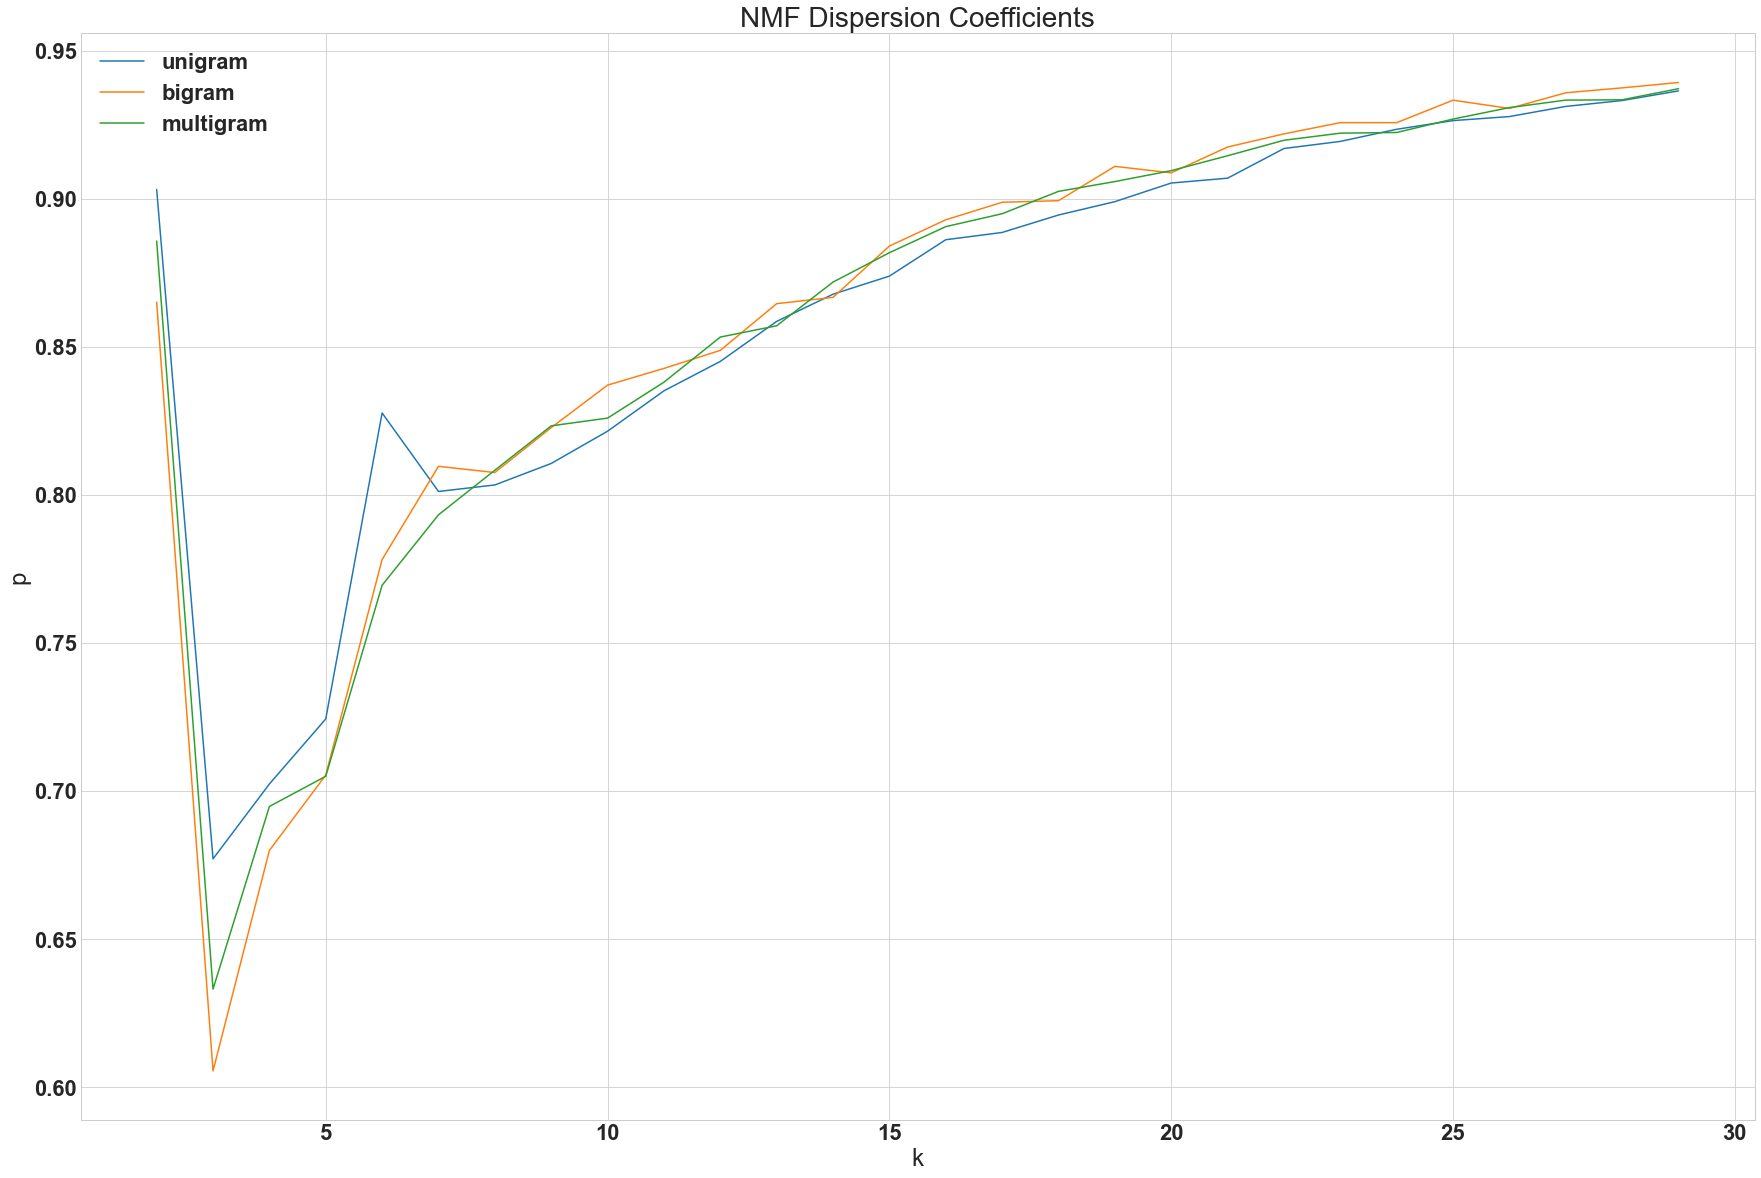

In [358]:
ax = plt.gca()

plt.title("NMF Dispersion Coefficients")

sns.lineplot(x=dispersion_df.columns, y=dispersion_df.loc["unigram"], ax=ax, label="unigram")
sns.lineplot(x=dispersion_df.columns, y=dispersion_df.loc["bigram"], ax=ax, label="bigram")
sns.lineplot(x=dispersion_df.columns, y=dispersion_df.loc["multigram"], ax=ax, label="multigram")

ax.set_xlabel("k")
ax.set_ylabel("p")

plt.savefig('./plots/nmf/dispersion_plot.pdf')
plt.show()

## Save Results

In [361]:
cluster_labels_df = service_innovation_df.copy()

for k in k_range:
    for config in config_range:
        cluster_labels_df[f"{config}_{k}"] = corpus_clusterer.models[config].nmf_cluster_labels(k)
    
cluster_labels_df.to_csv("./results/nmf_clusters.csv")